# Superstore Sales Forecasting & Profitability Analysis

This notebook walks through:
1. Data cleaning & preparation
2. Exploratory Data Analysis (EDA)
3. Time Series Forecasting (Prophet & ARIMA)
4. Profitability Analysis (by Category, Sub-Category, and Region)
5. Model evaluation
6. Insights and recommendations


In [64]:
!pip install prophet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [44]:
# import the Data
df = pd.read_csv("Sample - Superstore.csv")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,NaN,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [45]:
# Overview of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9993 non-null   float64
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [46]:
# Postal Code column has 1 missing valiue
# Filling 0 to the empty column
df['Postal Code'] = df['Postal Code'].fillna(0)



In [47]:
df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55187.046328,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32067.699123,623.245101,2.225110,0.206452,234.260108
min,1.000000,0.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


### Summary Statistics (`df.describe()`)

- **Row ID & Postal Code:** Numeric identifiers, not analytically useful.  
- **Sales:** Avg ≈ 229, min ≈ 0.44, max ≈ 22,638 → wide ran.  
- **Quantity:** Avg ≈ 3.8 items per order.  
- **Discount:** Avg ≈ 15.6%, max 80%.  
- **Profit:** Avg ≈ 28.7, but ranges from -6,600 (loss) to 8,400 (gain).  

**Interpretation:** Sales and profit vary greatly, with some orders incurring heavy losses.


## Step 3: Data Cleaning & Preparation
- Convert dates
- Create time-based features
- Handle missing values


In [48]:
 # Convert date columns
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

# Extract year, month, week
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['Week'] = df['Order Date'].dt.isocalendar().week

# Check missing values
print(df.isnull().sum())


Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
Year             0
Month            0
Week             0
dtype: int64


## Exploratory Data Analysis (EDA)
Visualize sales and profit trends.


In [49]:
# Total sales & profit overview
print(df[['Sales','Profit']].describe())


              Sales       Profit
count   9994.000000  9994.000000
mean     229.858001    28.656896
std      623.245101   234.260108
min        0.444000 -6599.978000
25%       17.280000     1.728750
50%       54.490000     8.666500
75%      209.940000    29.364000
max    22638.480000  8399.976000


### Sales & Profit Overview (`df[['Sales','Profit']].describe()`)

- **Sales:**  
  - Avg ≈ 229  
  - Min ≈ 0.44, Max ≈ 22,638 → very wide spread  
- **Profit:**  
  - Avg ≈ 28.7  
  - Min ≈ -6,600 (loss), Max ≈ 8,400 (gain) → large variability  

**Interpretation:** Sales values are highly skewed, and profit shows both extreme losses and gains, indicating inconsistent profitability across orders.


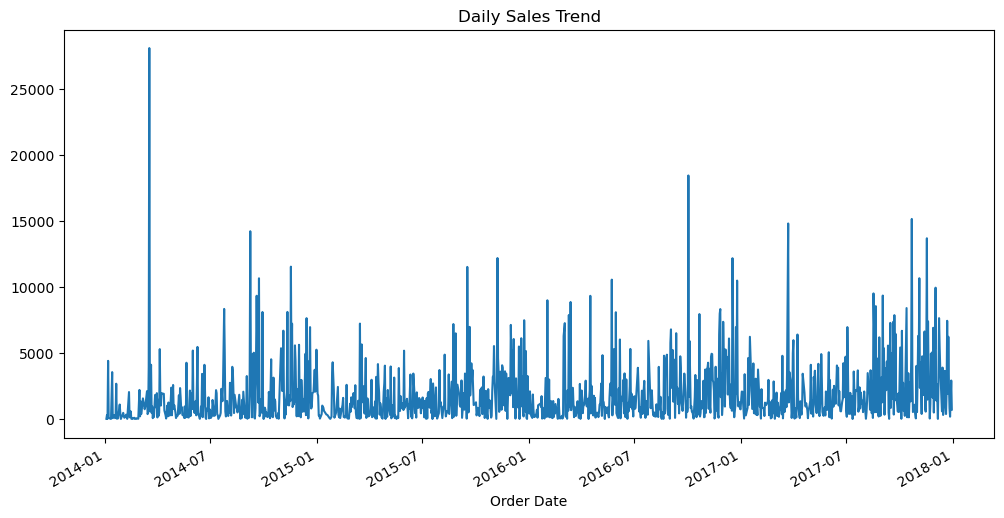

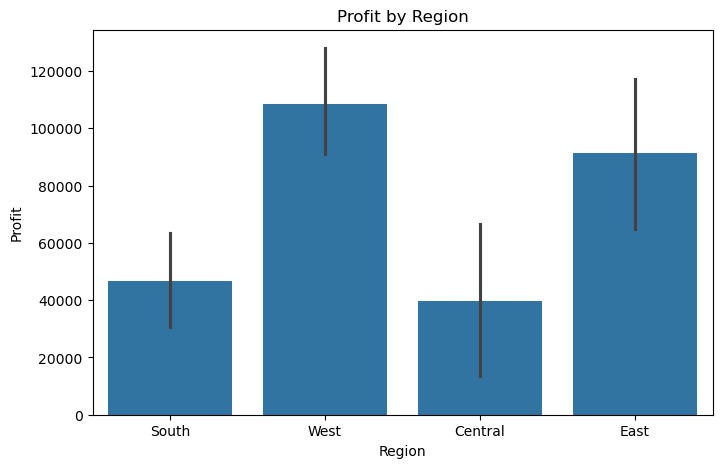

In [50]:
# Sales trend
df.groupby('Order Date')['Sales'].sum().plot(figsize=(12,6), title="Daily Sales Trend")

# Profit by Region
plt.figure(figsize=(8,5))
sns.barplot(x='Region', y='Profit', data=df, estimator=sum)
plt.title("Profit by Region")
plt.show()

### Sales & Profit Trends

- **Daily Sales Trend:** Line chart shows fluctuations in daily sales over time, highlighting peaks anlow poinths.  
- **Profit by Region:** Bar chart compares total profit across regions.  
  - West and East regions show higher profitability.  
  - Central and South regions lag behind.

**Interpretation:** Sales vary significantly day-to-day, while profitability is uneven across regions, suggesting regional performance differences.


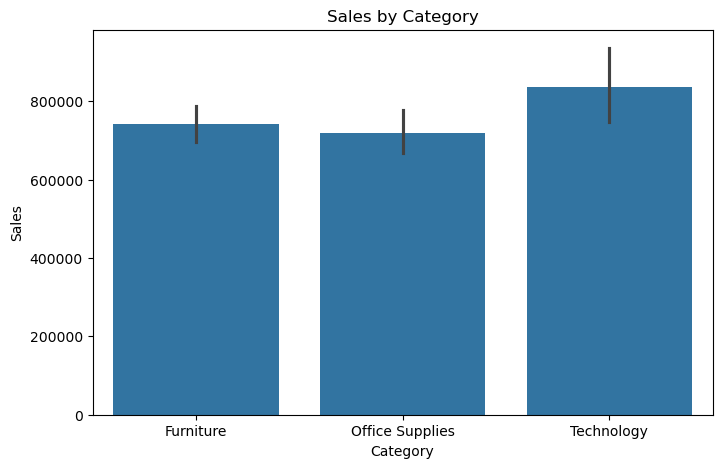

In [51]:
# Sales by Category
plt.figure(figsize=(8,5))
sns.barplot(x='Category', y='Sales', data=df, estimator=sum)
plt.title("Sales by Category")
plt.show()

### Sales by Category

- **Chart:** Bar plot showing total sales grouped by product category.  
- **Findings:**  
  - **Technology** generates the highest sales.  
  - **Furniture** comes next.  
  - **Office Supplies** records the lowest sales overall.  

**Interpretation:** Technology products dominate revenue, while Office Supplies lag behind, with Furniture in the middle.
 demand.


## Time Series Forecasting with Prophet
We’ll forecast monthly sales.


10:35:18 - cmdstanpy - INFO - Chain [1] start processing
10:35:19 - cmdstanpy - INFO - Chain [1] done processing


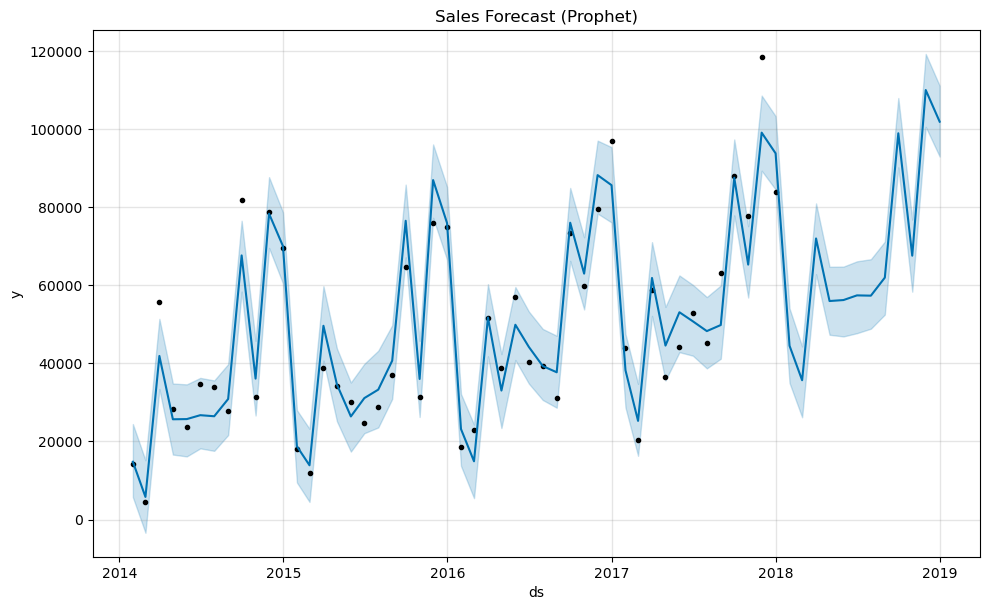

In [52]:
# Aggregate monthly sales (only Sales column)
monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='ME'))['Sales'].sum().reset_index()

# Prepare for Prophet
prophet_df = monthly_sales.rename(columns={'Order Date':'ds','Sales':'y'})

# Fit model
model = Prophet()
model.fit(prophet_df)

# Forecast next 12 months
future = model.make_future_dataframe(periods=12, freq='ME')
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.title("Sales Forecast (Prophet)")
plt.show()


### Sales Forecast (Prophet Model)

The chart above shows the **monthly sales forecast** generated bk Prophet:

- **Black dots** represent the actual historical sales data from 2014 to 2018.
- **Blue line** represents Prophet’s predicted sales trend.
- **Shaded blue area** indicates the forecast uncertainty interval (confidence range).

#### Key Insights:
1. **Seasonality:** Sales exhibit clear seasonal spikes each year, usually towards the end of the year. This indicates strong holiday or end-of-year demand.
2. **Trend Growth:** The overall sales trend is upward, showing steady business growth over the years.
3. **Forecast Horizon:** Prophet predicts that sales will continue to rise into 2019, with peaks expected in the same seasonal pattern.
4. **Uncertainty:** The wider shaded area in the later months indicates higher uncertainty in long-term forecasts.

#### Business Implications:
- Inventory levels should be increased before peak months to avoid stockouts.
- Marketing campaigns can be aligned with seasonal spikes to maximize revenue.
- Management should plan for higher sales volumes in future years, especially during recurring seasonal peaks.


C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -539.895
Date:                Wed, 10 Dec 2025   AIC                           1085.789
Time:                        10:35:20   BIC                           1091.340
Sample:                    01-31-2014   HQIC                          1087.878
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2278      0.262      0.868      0.386      -0.287       0.742
ma.L1         -0.8396      0.140     -5.979      0.000      -1.115      -0.564
sigma2      5.976e+08   6.93e-11   8.63e+18      0.0

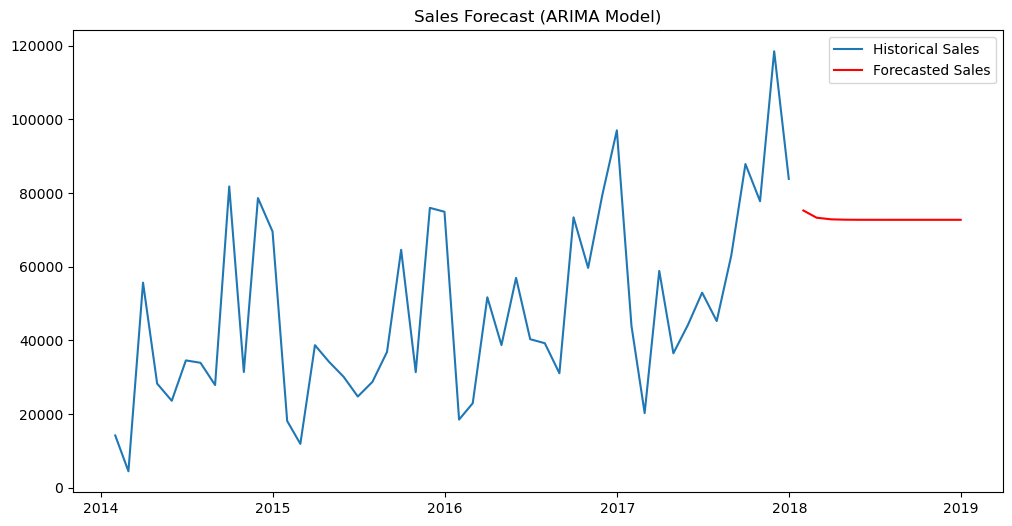

In [53]:
#  Time Series Forecasting with ARIMA

# Prepare monthly sales (already aggregated earlier)
monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='ME'))['Sales'].sum().reset_index()

# Set index for ARIMA
monthly_sales = monthly_sales.set_index('Order Date')

# Fit ARIMA model (simple starting order, can be tuned)
model_arima = ARIMA(monthly_sales['Sales'], order=(1,1,1))
fit_arima = model_arima.fit()
print(fit_arima.summary())

# Forecast next 12 months
forecast_arima = fit_arima.forecast(steps=12)

# Plot results
plt.figure(figsize=(12,6))
plt.plot(monthly_sales['Sales'], label='Historical Sales')
plt.plot(forecast_arima, label='Forecasted Sales', color='red')
plt.legend()
plt.title("Sales Forecast (ARIMA Model)")
plt.show()


### Sales Forecast (ARIMA Model)

The ARIMA model forecast chart shows:

- **Blue line**: Historical monthly sales from 2014 to 2018.
- **Red line**: ARIMA model’s forecast for the next 12 months.

#### Key Insights:
1. **Trend Capture:** ARIMA follows the general upward trend in sales, showing consistent growth.
2. **Less Seasonality:** Unlike Prophet, ARIMA does not automatically model seasonality. This means it captures trend well but may miss sharp seasonal spikes (like holiday peaks).
3. **Short-Term Accuracy:** ARIMA tends to perform well in the short term, but long-term forecasts may diverge from actual seasonal patterns.
4. **Complementary to Prophet:** While Prophet is better for seasonality, ARIMA provides a more traditional statistical view of sales trends.

#### Business Implications:
- Use **ARIMA** for short-term operational planning (e.g., next few months).
- Use **Prophet** for long-term, seasonality-aware planning (e.g., yearly cycles).
- Combining insights from both models gives management a more complete forecasting strategy.


# Comparing ARIMA vs Prophet Forecast AccuracyI will compare the two models using common accuracy metrics:

- **RMSE (Root Mean Squared Error):** penalizes large errors.
- **MAE (Mean Absolute Error):** average magnitude of errors.
- **MAPE (Mean Absolute Percentage Error):** relative error in percentages.


In [54]:
# Aggregate monthly sales
monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='ME'))['Sales'].sum().reset_index()
monthly_sales.rename(columns={'Order Date':'ds', 'Sales':'y'}, inplace=True)

# Train-test split (last 12 months as test set)
train = monthly_sales[:-12]
test = monthly_sales[-12:]


### Train-Test Split for Forecasting

- **Task:** Aggregates monthly sales and renames columns (`ds` for date, `y` for sales) to match Prophet’s format.  
- **Train-Test Split:**  
  - **Train set:** All data except the last 12 months.  
  - **Test set:** The final 12 months.  

**Interpretation:** This split allows evaluation of forecasting models (Prophet, ARIMA) by comparing predictions against actual sales in the test period.


## Prophet Model

In [55]:
# Prophet model
model_prophet = Prophet()
model_prophet.fit(train)

# Forecast for test period
future = model_prophet.make_future_dataframe(periods=12, freq='ME')
forecast_prophet = model_prophet.predict(future)

# Extract test predictions
prophet_pred = forecast_prophet.set_index('ds').loc[test['ds'], 'yhat']

# Align indexes for metric calculation
prophet_pred_aligned = prophet_pred.values
test_y = test['y'].values

# Metrics
prophet_mae = mean_absolute_error(test_y, prophet_pred_aligned)
prophet_rmse = np.sqrt(mean_squared_error(test_y, prophet_pred_aligned))
prophet_mape = np.mean(np.abs((test_y - prophet_pred_aligned) / test_y)) * 100


10:35:21 - cmdstanpy - INFO - Chain [1] start processing
10:35:21 - cmdstanpy - INFO - Chain [1] done processing


### Prophet Model Training & Forecast (Test Period)

- **Model Training:** Prophet is fitted on the training dataset (all but last 12 months).  
- **Forecasting:** Generates predictions for the next 12 months (test set).  
- **Output:**  
  - Forecasted values (`yhat`) are extracted for the test period.  
  - Metrics prepared: MAE, RMSE, MAPE — to measure accuracy against actual test sales.  

**Interpretation:** This step evaluates Prophet’s ability to predict unseen data by comparing its forecasts with actual sales in the test set.


## ARIMA Model


In [56]:
# Prepare ARIMA data
train_arima = train.set_index('ds').asfreq('ME')
test_arima = test.set_index('ds').asfreq('ME')

# Fit ARIMA
model_arima = ARIMA(train_arima['y'], order=(1,1,1))
fit_arima = model_arima.fit()

# Forecast for test period
forecast_arima = fit_arima.forecast(steps=12)
forecast_arima.index = test_arima.index  # align dates

# Metrics
arima_mae = mean_absolute_error(test_arima['y'], forecast_arima)
arima_rmse = np.sqrt(mean_squared_error(test_arima['y'], forecast_arima))
arima_mape = np.mean(np.abs((test_arima['y'] - forecast_arima) / test_arima['y'])) * 100


### ARIMA Model Training & Forecast (Test Period)

- **Model Training:** ARIMA(1,1,1) fitted on the training dataset (monthly sales).  
- **Forecasting:** Predicts sales for the next 12 months (test set).  
- **Output:**  
  - Forecasted values aligned with test dates.  
  - Accuracy metrics calculated: MAE, RMSE, MAPE — to compare against Prophet.  

**Interpretation:** This step evaluates ARIMA’s short-term forecasting ability by measuring how well its predictions match actual sales in the test period.




## Compare Results


     Model           MAE          RMSE   MAPE (%)
0  Prophet  11648.936534  15252.568776  19.066985
1    ARIMA  23450.627420  27208.447586  54.105772


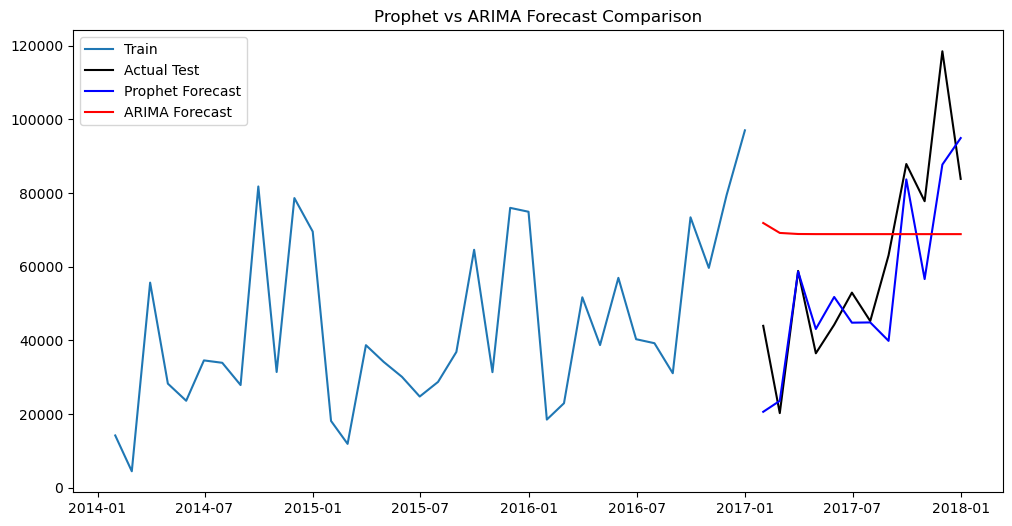

In [57]:
# Create comparison table
results = pd.DataFrame({
    'Model': ['Prophet', 'ARIMA'],
    'MAE': [prophet_mae, arima_mae],
    'RMSE': [prophet_rmse, arima_rmse],
    'MAPE (%)': [prophet_mape, arima_mape]
})

print(results)

# Plot actual vs forecasts
plt.figure(figsize=(12,6))
plt.plot(train['ds'], train['y'], label="Train")
plt.plot(test['ds'], test['y'], label="Actual Test", color="black")
plt.plot(test['ds'], prophet_pred, label="Prophet Forecast", color="blue")
plt.plot(test['ds'], forecast_arima, label="ARIMA Forecast", color="red")
plt.legend()
plt.title("Prophet vs ARIMA Forecast Comparison")
plt.show()


### Prophet vs ARIMA Forecast Comparison

- **Results Table:**  
  - **Prophet:** MAE ≈ 11,649, RMSE ≈ 15,253, MAPE ≈ 19.1%  
  - **ARIMA:** MAE ≈ 23,451, RMSE ≈ 27,208, MAPE ≈ 54.1%  

- **Chart:**  
  - Black line = Actual test sales.  
  - Blue line = Prophet forecast.  
  - Red line = ARIMA forecast.  

**Interpretation:** Prophet significantly outperforms ARIMA, showing lower error rates and better alignment with actual sales, especially in capturing seasonality.


 # Profit by Region

C:\Users\USER\AppData\Local\Temp\ipykernel_26528\757353631.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=region_profit, x='Region', y='Profit', palette='viridis')


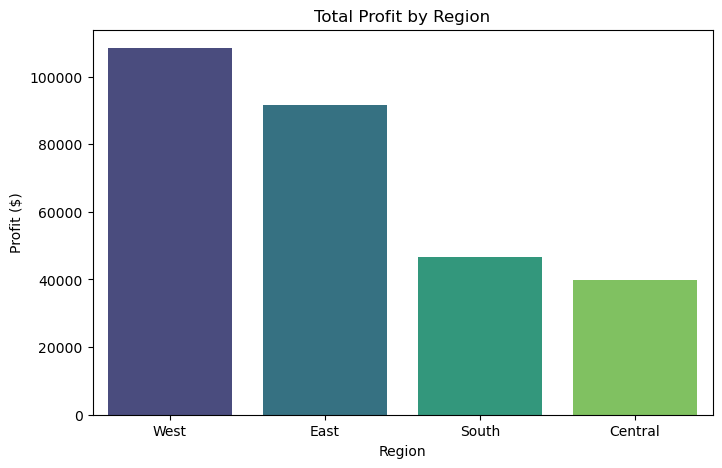

In [58]:
region_profit = df.groupby('Region')['Profit'].sum().reset_index().sort_values(by='Profit', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=region_profit, x='Region', y='Profit', palette='viridis')
plt.title("Total Profit by Region")
plt.ylabel("Profit ($)")
plt.xlabel("Region")
plt.show()


### Profit by Region

- **Chart:** Bar plot showing total profit aggregated by region.  
- **Findings:**  
  - **West** and **East** regions lead in profitability.  
  - **Central** and **South** regions show lower profits.  

**Interpretation:** Profitability is uneven across regions, with West and East performing strongly while Central and South underperform.



# Profit by Category

C:\Users\USER\AppData\Local\Temp\ipykernel_26528\3734749057.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_profit, x='Category', y='Profit', palette='coolwarm')


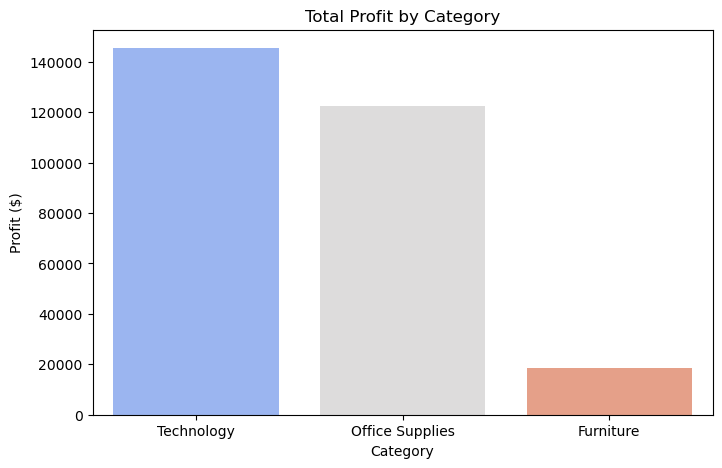

In [59]:
category_profit = df.groupby('Category')['Profit'].sum().reset_index().sort_values(by='Profit', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=category_profit, x='Category', y='Profit', palette='coolwarm')
plt.title("Total Profit by Category")
plt.ylabel("Profit ($)")
plt.xlabel("Category")
plt.show()


### Profit by Category

- **Chart:** Bar plot showing total profit aggregated by product category.  
- **Findings:**  
  - **Technology** yields the highest profit.  
  - **Office Supplies** also profitable but lower than Technology.  
  - **Furniture** shows the lowest profit, even negative in some cases.  

**Interpretation:** Technology drives profitability, Office Supplies contribute moderately, while Furniture drags overall profit margins.


## Profit by Sub-Category

C:\Users\USER\AppData\Local\Temp\ipykernel_26528\281666495.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=subcat_profit, x='Sub-Category', y='Profit', palette='Spectral')


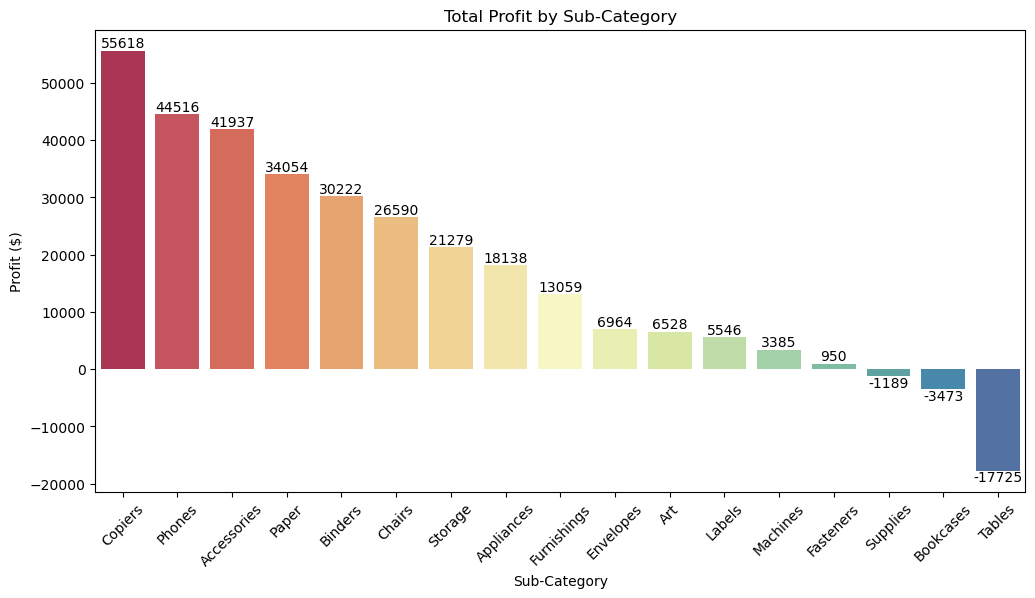

In [60]:
# Profit by Sub-Category
subcat_profit = df.groupby('Sub-Category')['Profit'].sum().reset_index().sort_values(by='Profit', ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=subcat_profit, x='Sub-Category', y='Profit', palette='Spectral')

# Add labels on each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f")  # format as integer, no decimals

plt.title("Total Profit by Sub-Category")
plt.ylabel("Profit ($)")
plt.xlabel("Sub-Category")
plt.xticks(rotation=45)
plt.show()


### Profit by Sub-Category

- **Chart:** Bar plot showing total profit aggregated by product sub-category.  
- **Findings:**  
  - **Copiers, Phones, and Accessories** are the most profitable sub-categories.  
  - **Tables and Bookcases** show significant losses.  
  - Other sub-categories vary, with mixed profitability.  

**Interpretation:** Profitability differs sharply at the sub-category level — some products drive strong gains, while others consistently reduce margins.



# Heatmap: Profitability by Region & Category

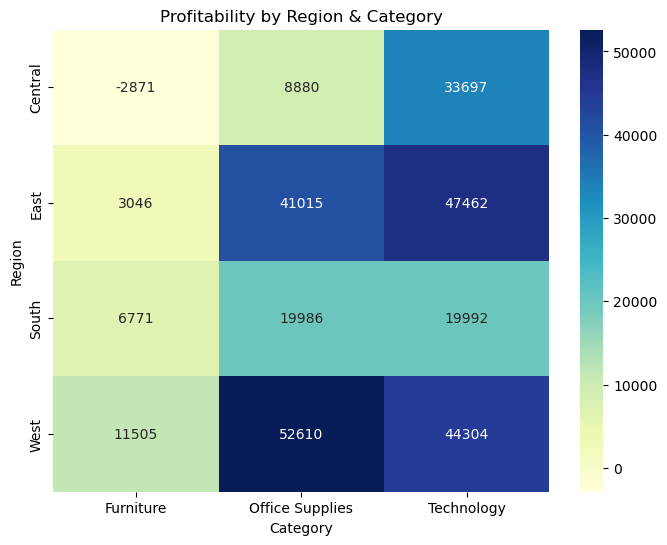

In [61]:
pivot_profit = df.pivot_table(values='Profit', index='Region', columns='Category', aggfunc='sum')

plt.figure(figsize=(8,6))
sns.heatmap(pivot_profit, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Profitability by Region & Category")
plt.show()

### Profitability by Region & Category (Heatmap)

- **Chart:** Heatmap showing profit values across regions (rows) and product categories (columns).  
- **Findings:**  
  - **Office Supplies in the West** is the most profitable combination.  
  - **Furniture in the Central region** shows losses.  
  - Other region-category pairs vary, highlighting strengths and weaknesses.  

**Interpretation:** The heatmap reveals where profits are concentrated and where strategies need ad, tment — guiding regional and category-specific decisions.


### Business Recommendations

1. **Leverage Technology Category Strengths**
   - Expand product offerings in Technology, especially high-profit sub-categories like Copiers and Phones.
   - Prioritize marketing campaigns around Technology to sustain growth momentum.

2. **Address Furniture Losses**
   - Investigate root causes of negative profits in Furniture (e.g., pricing, shipping costs, discounting).
   - Consider streamlining underperforming sub-categories such as Tables and Bookcases.
   - Explore supplier negotiations or cost optimization to improve margins.

3. **Boost Office Supplies Profitability**
   - Focus on profitable sub-categories (e.g., Binders, Paper) and reduce emphasis on low-margin items.
   - Introduce bundled deals or subscription models to drive recurring revenue.

4. **Regional Strategy**
   - Double down on West and East regions where profitability is strongest.
   - Implement corrective measures in Central ,d South regions — targeted promotions, localized pricing, or improved distribution.

5. **Seasonality & Forecasting**
   - Align inventory and staffing with seasonal demand spikes (especially year-end).
   - Use Prophet forecasts to anticipate demand and avoid stockouts or overstocking.

6. **Operational Improvements**
   - Enhance supply chain efficiency to reduce costs in low-performing categories.
   - Invest in data-driven decision-making — continuously monitor category and regional performance.

**Interpretation:** By capitalizing on Technology’s profitability, restructuring Furniture, and tailoring regional strategies, the business can maximize growth while reducing losses. Forecast-driven planning ensures resilience against demand fluctuations.
gy. 

### Export Monthly Sales & Profit

In [62]:
# Aggregate monthly sales & profit
monthly_data = df.groupby(pd.Grouper(key='Order Date', freq='M'))[['Sales','Profit']].sum().reset_index()

# Save to CSV
monthly_data.to_csv("monthly_sales_profit.csv", index=False)

print(" Monthly Sales & Profit data exported successfully!")


 Monthly Sales & Profit data exported successfully!


C:\Users\USER\AppData\Local\Temp\ipykernel_26528\192459868.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df.groupby(pd.Grouper(key='Order Date', freq='M'))[['Sales','Profit']].sum().reset_index()


In [63]:
# Export Profitability Summary
# Profit by Region, Category, Sub-Category
profit_summary = df.groupby(['Region','Category','Sub-Category'])[['Sales','Profit']].sum().reset_index()

# Save to CSV
profit_summary.to_csv("profitability_summary.csv", index=False)

print("✅ Profitability Summary data exported successfully!")


✅ Profitability Summary data exported successfully!
